##Comparison of state-of-the-art univariate and multivariate CSC methods

In this notebook we compare the time for state of the art methods for uni-variate signal: (1) CBPDN, (2) Fista, (3) LBFGS, (4) LGCD; and for multivariate signal: (1) LGCD with full rank, (2) LGCD with rank-1 constarint, (3) CBPDN to converge with different values of the regularization parameter, $\lambda$.
Most of the code in this notebook is taken from [alphacsc library ](https://github.com/alphacsc/alphacsc) which is relatd to [1] \\

The CSC problem is convex in each variable alone but not jointly conve. Thus the solution depends on the initialization. For this, we will run the algorithms with different initializations. \\


[1]
Dupré La Tour, T., Moreau, T., Jas, M., & Gramfort, A. (2018). Multivariate Convolutional Sparse Coding for Electromagnetic Brain Signals. Advances in Neural Information Processing Systems (NIPS).

 

**Univariate CSC Formulation**

For a univarite signal $\mathbf{\{x^{n}\}_{n=1}^{N}}\subset\mathbb{R}^T$ with $N$ observed signals, the convolutional sparse coding task amounts to solve the following optimization problem:

$$
\min_{\{\mathbf{d}_k\}_k, \{\mathbf{z}_k ^{n}\}_{k,n} \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \sum_{n=1}^{N}\frac{1}{2}\quad\left\lVert \mathbf{x^{n}} - \sum_{k=1}^K \mathbf{z}_{k}^{n} * \mathbf{d}_k \right\rVert_{2}^{2} \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_{k}^{n}\rVert_1
$$

where $\mathbf\{{d}\}_{k=1}^{K}\subset\mathbb{R}^L$ are the $K$ temporal atoms (patterns) that we aim to learn, and $\mathbf\{{z_{k}^{n}}\}_{k=1}^{K}\in\mathbb{R}^{N-L+1}$ are $K$ activations signals, and $\lambda>0$ is the sparsity constraint. 


**Multivariate CSC Formulation**

For multivariate signals $\mathbf{\{X^{n}\}_{n=1}^{N}}\subset\mathbb{R}^{P \times T}$ with $N$ observed multivariate recorded over $P$ channels, the convolutional sparse coding task amounts to solve the following optimization problem:

$$
\min_{\{\mathbf{D}_k\}_k, \{\mathbf{z}_k ^{n}\}_{k,n} \\ \lVert\mathbf{D}_k\rVert_{2}^{2}\leq 1, z_{k}^{n} \geq 0} \sum_{n=1}^{N}\frac{1}{2}\quad\left\lVert \mathbf{X^{n}} - \sum_{k=1}^K \mathbf{z}_{k}^{n} * \mathbf{D}_k \right\rVert_{2}^{2} \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_{k}^{n}\rVert_1
$$

where $\mathbf\{{D}\}_{k=1}^{K}\subset\mathbb{R}^{P \times L}$ are the $K$ spatio-temporal atoms (patterns) that we aim to learn, and $\mathbf\{{z_{k}^{n}}\}_{k=1}^{K}\in\mathbb{R}^{N-L+1}$ are the sparese activations associated with $X^{n}$, and $\lambda>0$ is the sparsity constraint. 



**MultiVariate CSC with rank-1 constraint**




The model is exactly the same as the multivariate case but with rank-1 constraint on the dictonary $D_{k} = u_{k} v_{k}^{T} \in \mathbb{R} ^{P \times L}$ with $u_{k} \in \mathbb{R}^{P}$ the pattern over the channels and $v_{k}$ the pattern over time. The optimization problem becomes as follows: 

$$
\min_{\{\mathbf{u}_k\}_k, \{\mathbf{v}_k\}_k, \{\mathbf{z}_k ^{n}\}_{k,n} \\ \lVert\mathbf{u}_k\rVert_{2}^{2}\leq 1, \lVert\mathbf{v}_k\rVert_{2}^{2}\leq 1 \\ z_{k}^{n} \geq 0} \sum_{n=1}^{N}\frac{1}{2}\quad\left\lVert \mathbf{X^{n}} - \sum_{k=1}^K \mathbf{z}_{k}^{n} * (\mathbf{u}_k  \mathbf{v}^{T}_k)\right\rVert_{2}^{2} \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_{k}^{n}\rVert_1
$$


## Setup


**Mount the code on google drive**, skip this step, or modify Folder_name with an existing folder you wish to mount this work to

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
Folder_name = 'MVA_TS/'
assert Folder_name is not None, "[1] Enter the folder name"

import sys 
sys.path.append('content/drive/MyDrive/{}'.format(Folder_name))
%cd drive/MyDrive/$Folder_name/


Mounted at /content/drive
/content/drive/MyDrive/MVA_TS


**Run on GPU**

In [ ]:
import torch
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}

**Clone the alphacsc repo**

In [ ]:
!git clone https://github.com/alphacsc/alphacsc.git


Cloning into 'alphacsc'...
remote: Enumerating objects: 4255, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 4255 (delta 153), reused 189 (delta 90), pack-reused 3934
Receiving objects: 100% (4255/4255), 12.62 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (2980/2980), done.


**Install**

In [ ]:
%matplotlib inline
!pip install git+https://github.com/alphacsc/alphacsc.git

  Cloning https://github.com/alphacsc/alphacsc.git to /tmp/pip-req-build-7szbx5js
  Running command git clone -q https://github.com/alphacsc/alphacsc.git /tmp/pip-req-build-7szbx5js
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.5 MB 15.7 MB/s 
  Created wheel for alphacsc: filename=alphacsc-0.4.0rc1.dev10+g9a9a28d-py3-none-any.whl size=4522717 sha256=83adfe1900663b0939d8bb2f81563a6390f798575f958be03fdb43902a462302
  Stored in directory: /tmp/pip-ephem-wheel-cache-clm2ntnm/wheels/f2/c8/79/1deb4d532b9fc61ffaace73a3d0f7b575e45ac3d91512f23a4
Successfully built alphacsc


In [ ]:
!pip install pandas pyfftw
!pip install alphacsc/alphacsc/other/sporco 

     |████████████████████████████████| 1.7 MB 21.6 MB/s 
Processing ./alphacsc/alphacsc/other/sporco
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for sporco: filename=sporco-0.1.9b1-py3-none-any.whl size=4337072 sha256=27ca2729369a9b31ef5fc5504d76c1783ec035a137c4dab3fad7782ba9578ea6
  Stored in directory: /tmp/pip-ephem-wheel-cache-efcbdk5i/wheels/fa/41/02/cfdcddaeed4807723e97f930d6d51c43563e4ad7df42cf9506
Successfully built sporco


**Imports**

In [ ]:
from __future__ import print_function
import os
import time
import itertools
import numpy as np
import pandas as pd
import scipy.sparse as sp
from joblib import Parallel, delayed
import alphacsc.other.heide_csc as CSC
from alphacsc.update_d import update_d_block
from alphacsc.learn_d_z import learn_d_z
from alphacsc.learn_d_z_multi import learn_d_z_multi
from alphacsc.datasets.mne_data import load_data
from alphacsc.init_dict import init_dictionary
from alphacsc.utils.dictionary import get_uv
from sporco.admm.cbpdndl import ConvBPDNDictLearn
import matplotlib
import matplotlib.pyplot as plt
import itertools



/usr/local/lib/python3.7/dist-packages/alphacsc/utils/compute_constants.py:29: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  uv[k, n_channels:])
/usr/local/lib/python3.7/dist-packages/alphacsc/utils/compute_constants.py:32: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  uv[k, n_channels + t:])
/usr/local/lib/python3.7/dist-packages/alphacsc/utils/compute_constants.py:34: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  uv[k, n_channels:-t])
/usr/local/lib/python3.7/dist-packages/alphacsc/utils/compute_constants.py:35: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  DtD *= np.dot(u, u.T).reshape(n_atoms, n_atoms, 1)


## Univariate CSC Algorithms

**[Admm Algorithm](https://ieeexplore.ieee.org/abstract/document/8364626?casa_token=6-H-y9v21-IAAAAA:7kUfLu0g_2UoQY3GqekziSt7XYKuQ9dz4CvvFGMwCnm_SchnF8aI4f4G0SvcOs-irNqhQoO5Dmkcaw)**

In [ ]:

def run_admm(X, ds_init, reg, n_iter, random_state, label, max_it_d=10,
             max_it_z=10):
    # admm with the following differences
    # - positivity constraints
    # - different init
    # - d step and z step are swapped
    tol = np.float64(1e-3)
    size_kernel = ds_init.shape
    assert size_kernel[1] % 2 == 1
    [d, z, Dz, list_obj_val, times_admm] = CSC.learn_conv_sparse_coder(
        X, size_kernel, max_it=n_iter, tol=tol, random_state=random_state,
        lambda_prior=reg, ds_init=ds_init, verbose=verbose, max_it_d=max_it_d,
        max_it_z=max_it_z)

    # z.shape = (n_trials, n_atoms, n_times + 2 * n_times_atom)
    z = z[:, :, 2 * n_times_atom:-2 * n_times_atom]
    z = z.swapaxes(0, 1)
    # z.shape = (n_atoms, n_trials, n_times - 2 * n_times_atom)

    return list_obj_val, np.cumsum(times_admm)[::2], d, z


**[Fista Algorithm](https://proceedings.neurips.cc/paper/2017/hash/6f2268bd1d3d3ebaabb04d6b5d099425-Abstract.html)**

In [ ]:
def run_fista(X, ds_init, reg, n_iter, random_state, label):
    assert X.ndim == 2
    n_atoms, n_times_atom = ds_init.shape
    pobj, times, d_hat, z_hat, reg = learn_d_z(X, n_atoms, n_times_atom, func_d=update_d_block, reg=reg, 
                    n_iter=n_iter, random_state=random_state, n_jobs=1, solver_z='fista', solver_z_kwargs=dict(max_iter=2), 
                    ds_init=ds_init, verbose=verbose)
    

    return pobj[::2], np.cumsum(times)[::2], d_hat, z_hat



**[LBFGS Algorithm](https://proceedings.neurips.cc/paper/2017/hash/6f2268bd1d3d3ebaabb04d6b5d099425-Abstract.html)**

In [ ]:
def run_l_bfgs(X, ds_init, reg, n_iter, random_state, label, factr_d=1e7,
               factr_z=1e14):
    assert X.ndim == 2
    n_atoms, n_times_atom = ds_init.shape
    pobj, times, d_hat, z_hat, reg = learn_d_z(
        X, n_atoms, n_times_atom,
        func_d=update_d_block, solver_z='l-bfgs', solver_z_kwargs=dict(
            factr=factr_z), reg=reg, n_iter=n_iter, solver_d_kwargs=dict(
                factr=factr_d), random_state=random_state, ds_init=ds_init,
        n_jobs=1, verbose=verbose)
    

    return pobj[::2], np.cumsum(times)[::2], d_hat, z_hat


**[CBPDN Algorithm](https://ieeexplore.ieee.org/abstract/document/8364626?casa_token=6-H-y9v21-IAAAAA:7kUfLu0g_2UoQY3GqekziSt7XYKuQ9dz4CvvFGMwCnm_SchnF8aI4f4G0SvcOs-irNqhQoO5Dmkcaw)**, used for both univariate and multivariate signals

In [ ]:

def run_cbpdn(X, ds_init, reg, n_iter, random_state, label):
    # Use only one thread in fft for fair comparison
    import sporco.linalg
    sporco.linalg.pyfftw_threads = 1

    if X.ndim == 2:  # univariate CSC
        ds_init = np.swapaxes(ds_init, 0, 1)[:, None, :]
        X = np.swapaxes(X, 0, 1)[:, None, :]
        single_channel = True
    else:  # multivariate CSC
        ds_init = np.swapaxes(ds_init, 0, 2)
        X = np.swapaxes(X, 0, 2)
        single_channel = False

    options = {
        'Verbose': verbose > 0,
        'StatusHeader': False,
        'MaxMainIter': n_iter,
        'CBPDN': dict(NonNegCoef=True),
        'CCMOD': dict(ZeroMean=False),
        'DictSize': ds_init.shape,
    }

    # wolberg / convolutional basis pursuit
    opt = ConvBPDNDictLearn.Options(options)
    cbpdn = ConvBPDNDictLearn(ds_init, X, reg, opt, dimN=1)
    results = cbpdn.solve()
    times = np.cumsum(cbpdn.getitstat().Time)

    d_hat, pobj = results
    if single_channel:  # univariate CSC
        d_hat = d_hat.squeeze().T
        n_atoms, n_times_atom = d_hat.shape
    else:
        d_hat = d_hat.squeeze().swapaxes(0, 2)
        n_atoms, n_channels, n_times_atom = d_hat.shape

    z_hat = cbpdn.getcoef().squeeze().swapaxes(0, 2)
    times = np.concatenate([[0], times])

    # z_hat.shape = (n_atoms, n_trials, n_times)
    z_hat = z_hat[:, :, :-n_times_atom + 1]
    # z_hat.shape = (n_atoms, n_trials, n_times_valid)

    return pobj, times, d_hat, z_hat

##Multivariate CSC Algorithms

**[LGCD](https://proceedings.neurips.cc/paper/2018/hash/64f1f27bf1b4ec22924fd0acb550c235-Abstract.html)** with rank_1

In [ ]:
def run_multichannel_gcd(X, ds_init, reg, n_iter, random_state, label):
    if X.ndim == 2:
        n_atoms, n_times_atom = ds_init.shape
        ds_init = np.c_[np.ones((n_atoms, 1)), ds_init]
        X = X[:, None, :]
    else:
        n_atoms, n_channels, n_times_atom = ds_init.shape
        ds_init = get_uv(ds_init)  # project init to rank 1

    solver_z_kwargs = dict(max_iter=2, tol=1e-3)
    pobj, times, d_hat, z_hat, reg = learn_d_z_multi(
        X, n_atoms, n_times_atom, solver_d='alternate_adaptive',
        solver_z="lgcd", uv_constraint='separate', eps=-np.inf,
        solver_z_kwargs=solver_z_kwargs, reg=reg, solver_d_kwargs=dict(
            max_iter=100), n_iter=n_iter, random_state=random_state,
        raise_on_increase=False, D_init=ds_init, n_jobs=1, verbose=verbose)

    # remove the ds init duration
    times[0] = 0

    return pobj[::2], np.cumsum(times)[::2], d_hat, z_hat

**[LGCD](https://proceedings.neurips.cc/paper/2018/hash/64f1f27bf1b4ec22924fd0acb550c235-Abstract.html)** with full rank

In [ ]:

def run_multichannel_gcd_fullrank(X, ds_init, reg, n_iter, random_state,
                                  label):
    assert X.ndim == 3
    n_atoms, n_channels, n_times_atom = ds_init.shape

    solver_z_kwargs = dict(max_iter=2, tol=1e-3)
    pobj, times, d_hat, z_hat, reg = learn_d_z_multi(
        X, n_atoms, n_times_atom, solver_d='fista', solver_z="lgcd",
        uv_constraint='auto', eps=-np.inf, solver_z_kwargs=solver_z_kwargs,
        reg=reg, solver_d_kwargs=dict(max_iter=100), n_iter=n_iter,
        random_state=random_state, raise_on_increase=False, D_init=ds_init,
        n_jobs=1, verbose=verbose, rank1=False)

    # remove the ds init duration
    times[0] = 0

    return pobj[::2], np.cumsum(times)[::2], d_hat, z_hat



##Utility Functions

In [ ]:
BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE = range(30, 38)
def colorify(message, color=BLUE):
    """Change color of the standard output"""
    return ("\033[1;%dm" % color) + message + "\033[0m"


**List of functions used in the benchmark**


In [ ]:
n_iter = 100
methods_univariate = [
    [run_cbpdn, 'Garcia-Cardona et al (2017)', n_iter * 2],
    [run_fista, 'Jas et al (2017) FISTA', n_iter],
    [run_l_bfgs, 'Jas et al (2017) LBFGS', n_iter],
    [run_multichannel_gcd, 'Proposed (univariate)', n_iter],
]

n_iter_multi = 20
methods_multivariate = [
    [run_cbpdn, 'Wohlberg (2016)', n_iter_multi * 2],
    [run_multichannel_gcd_fullrank, 'Proposed (multivariate)', n_iter_multi],
    [run_multichannel_gcd, 'Proposed (multichannel)', n_iter_multi],
]

**Helper method to call CSC function**

In [ ]:
def one_run(X, X_shape, random_state, method, n_atoms, n_times_atom, reg):
    assert X.shape == X_shape
    func, label, n_iter = method
    current_time = time.time() - START
    msg = ('%s - %s: started at T=%.0f sec' % (random_state, label,
                                               current_time))
    print(colorify(msg, BLUE))

    if len(X_shape) == 2:
        n_trials, n_times = X.shape
        n_channels = 1
        X_init = X[:, None, :]
    else:
        n_trials, n_channels, n_times = X.shape
        X_init = X

    # use the same init for all methods
    ds_init = init_dictionary(X_init, n_atoms, n_times_atom, D_init='chunk',
                              rank1=False, uv_constraint='separate',
                              random_state=random_state)
    if len(X_shape) == 2:
        ds_init = ds_init[:, 0, :]

    # run the selected algorithm with one iter to remove compilation overhead
    _, _, _, _ = func(X, ds_init, reg, 1, random_state, label)

    # run the selected algorithm
    pobj, times, d_hat, z_hat = func(X, ds_init, reg, n_iter, random_state,
                                     label)

    # store z_hat in a sparse matrix to reduce size
    for z in z_hat:
        z[z < 1e-3] = 0
    z_hat = [sp.csr_matrix(z) for z in z_hat]

    duration = time.time() - START - current_time
    current_time = time.time() - START
    msg = ('%s - %s: done in %.0f sec at T=%.0f sec' %
           (random_state, label, duration, current_time))
    print(colorify(msg, GREEN))
    return (random_state, label, np.asarray(pobj), np.asarray(times),
            np.asarray(d_hat), np.asarray(z_hat), n_atoms, n_times_atom,
            n_trials, n_times, n_channels, reg)



**Helper method to run experiments**



In [ ]:
def run_exps(n_times_atom_list, n_atoms_list, n_channel_list, reg_list):


  out_iterator = itertools.product(n_times_atom_list, n_atoms_list,
                                     n_channel_list, reg_list)

  for params in out_iterator:
      n_times_atom, n_atoms, n_channels, reg = params
      msg = 'n_times_atom, n_atoms, n_channels, reg = ' + str(params)
      print(colorify(msg, RED))
      print(colorify('-' * len(msg), RED))

      save_name = base_name + str(params)
      save_name = os.path.join('figures', save_name)

      all_results = []

      X, info = load_data(
         dataset='sample', epoch=False, n_jobs=n_jobs
      )

      if n_channels == 1:
         X = X[:, 0, :]  # take only one channel
      elif n_channels is not None:
         X = X[:, :n_channels, :]

      assert X.shape[0] > 1  # we need at least two trials for sporco
      X_shape = X.shape

      if n_channels == 1:
         methods = methods_univariate
      else:
         methods = methods_multivariate

      iterator = itertools.product(methods, range(n_states))
      if n_jobs == 1:
       for method, random_state in iterator:  
         results = [ one_run(X, X_shape, random_state, method, n_atoms, n_times_atom, reg)]
      else:
        # run the methods for different random_state
         delayed_one_run = delayed(one_run)
         results = Parallel(n_jobs=n_jobs)(delayed_one_run(
            X, X_shape, random_state, method, n_atoms, n_times_atom,
            reg) for method, random_state in iterator)

      all_results.extend(results)

      all_results_df = pd.DataFrame(
        all_results, columns='random_state label pobj times d_hat '
        'z_hat n_atoms n_times_atom n_trials n_times n_channels reg'.
        split(' '))
  
      isExist = os.path.exists('figures')
      if not isExist:
        os.makedirs('figures')
      all_results_df.to_pickle(save_name + '.pkl')

  print('-- End of the script --')

**To color the plots**

In [ ]:
def color_palette(n_colors=4, cmap='viridis', extrema=False):
    """Create a color palette from a matplotlib color map"""
    if extrema:
        bins = np.linspace(0, 1, n_colors)
    else:
        bins = np.linspace(0, 1, n_colors * 2 - 1 + 2)[1:-1:2]

    cmap = plt.get_cmap(cmap)
    palette = list(map(tuple, cmap(bins)[:, :3]))
    return palette


**To plot different algorithms**

In [ ]:
def normalize_pobj(pobj, best_pobj=None, normalize_method='best'):
    """Normalize the objective function"""
    if normalize_method == 'best':
        assert best_pobj is not None
        pobj = (pobj - best_pobj) / best_pobj
    elif normalize_method == 'last':
        pobj = [(p - p.min()) / p.min() for p in pobj]
        pobj = [p / p[0] if p[0] != 0 else p for p in pobj]
    elif normalize_method == 'diff':
        pobj = [-np.diff(p) for p in pobj]
    elif normalize_method in [None, 'short']:
        pass
    else:
        raise ValueError('unknown normalize_method: %s' % normalize_method)

    return pobj


**To plot the convergence curves**

In [ ]:
def plot_convergence(data_frame, threshold, normalize_method, save_name):
    save_name += '_%s' % (normalize_method, )
    for n_atoms in data_frame['n_atoms'].unique():

        for n_times_atom in data_frame['n_times_atom'].unique():
            this_res = data_frame
            this_res = this_res[this_res['n_atoms'] == n_atoms]
            this_res = this_res[this_res['n_times_atom'] == n_times_atom]
            labels = this_res['label'].unique()

            if this_res.size == 0:
                continue

            best_pobj = min([min(pobj) for pobj in this_res['pobj']])

            # draw a different figure for each setting
            fig = plt.figure(figsize=(6, 4))
            ax = fig.gca()
            plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
            # ymin = np.inf
            tmax = []
            colors = color_palette(len(labels))
            for label, color in zip(labels, colors):
                if label == 'find_best_pobj':
                    continue
                # aggregate all runs (different random states)
                this_res_2 = this_res[this_res['label'] == label]
                times = this_res_2['times']
                pobj = this_res_2['pobj']

                pobj = normalize_pobj(pobj, best_pobj, normalize_method)

                # geometric mean on the n_iter_min first iterations
                n_iter_min = min([t.shape[0] for t in pobj])
                pobj_stack = np.vstack([p[:n_iter_min] for p in pobj])
                pobj_stack = np.log10(pobj_stack + 1e-15)
                pobj_mean = 10 ** (np.mean(pobj_stack, axis=0))
                times_mean = np.vstack([t[:n_iter_min] for t in times])
                times_mean = times_mean.mean(axis=0)
                if times_mean.size == 0:
                    continue
                tmax.append(times_mean[-1])

                times_mean = times_mean[1:]
                pobj_mean = pobj_mean[1:]

                if normalize_method == 'last':
                    last = np.where(pobj_mean <= threshold)[0]
                    if last.size == 0:
                        continue
                    last = last[0]
                    times_mean = times_mean[:last]
                    pobj_mean = pobj_mean[:last]

                style = '--' if 'Proposed' in label else '-'

                # plot the mean
                plt.plot(times_mean, pobj_mean, style, label=label,
                         alpha=1., markevery=0.1, lw=2., color=color)

                if normalize_method not in [None, 'short']:
                    ax.set_xscale('log')
                    ax.set_yscale('log')

            plt.xlabel('Time (s)')
            if normalize_method in [None, 'short']:
                plt.ylabel('objective')
                if normalize_method == 'short' and tmax != []:
                    xmax = 10 ** np.mean(np.log10(tmax)) / 5
                    plt.xlim(-xmax / 20, xmax)
            elif normalize_method == 'diff':
                plt.ylabel('diff(objective)')
            elif normalize_method == 'last':
                plt.ylabel('(objective_i - best_i) / (init - best_i)')
            else:
                plt.ylabel('(objective - best) / best')

            # ---- Cleaner fig for the paper
            # plt.legend(loc=0, ncol=1)
            plt.ylabel('')

            # plt.ylim(ymin=ymin / 10)
            # plt.title('K = %d, L = %d' % (n_atoms, n_times_atom))
            plt.gca().tick_params(axis='x', which='both', bottom='off',
                                  top='off')
            plt.gca().tick_params(axis='y', which='both', left='off',
                                  right='off')
            plt.grid(True)
            plt.tight_layout()

            try:
                reg = min(this_res_2['reg'].unique())
            except:
                reg = None
            this_save_name = (save_name + '_bench_K%d_L%d_r%s' %
                              (n_atoms, n_times_atom, reg))

            fig.savefig(this_save_name + '.png', dpi=150)

**Barplots** that shows the time that the algorithm take to converge with different values of the regulirzation parameter

In [ ]:
def plot_barplot(all_results_df, threshold, normalize_method, save_name):
    all_results_df = all_results_df.sort_values(by=['reg'], kind='mergesort')

    if normalize_method is None:
        return None
    save_name += '_%s_%s' % (normalize_method, threshold)
    labels = all_results_df['label'].unique()
    to_plot = []
    iterator = itertools.product(
        all_results_df['n_channels'].unique(),
        all_results_df['n_atoms'].unique(),
        all_results_df['n_times_atom'].unique(),
        all_results_df['n_times'].unique(),
        all_results_df['reg'].unique(),
        labels, )
    for n_channels, n_atoms, n_times_atom, n_times, reg, label in iterator:
        setting = 'T_%d, P=%d, K=%d, L=%d' % (n_times, n_channels, n_atoms,
                                              n_times_atom)
        this_res = all_results_df
        this_res = this_res[this_res['n_atoms'] == n_atoms]
        this_res = this_res[this_res['n_times_atom'] == n_times_atom]
        this_res = this_res[this_res['n_times'] == n_times]
        this_res = this_res[this_res['n_channels'] == n_channels]
        this_res = this_res[this_res['reg'] == reg]
        this_res = this_res[this_res['label'] == label]

        if this_res.size == 0:
            continue

        # aggregate all runs (different random states)
        times = this_res['times']
        pobj = this_res['pobj']

        pobj = normalize_pobj(pobj, None, normalize_method)

        # find first time instant where pobj go below threshold
        first_time_list = []
        for pobj_, times_ in zip(pobj, times):
            idx = np.where(pobj_ < threshold)[0]
            if idx.size != 0:
                first_time_list.append(times_[idx[0]])
        first_time_list = np.array(first_time_list)

        mean = np.exp(np.mean(np.log(first_time_list)))
        std = None
        to_plot.append((reg, first_time_list, mean, std, label, setting))

    to_plot_df = pd.DataFrame(to_plot, columns=[
        'reg', 'first_time', 'mean', 'std', 'label', 'setting'
    ])

    settings = to_plot_df['setting'].unique()

    for setting in settings:
        this_to_plot_df = to_plot_df[to_plot_df['setting'] == setting]

        labels = this_to_plot_df['label'].unique()
        width = 1. / (labels.size + 2)  # the width of the bars
        colors = color_palette(len(labels))

        regs = this_to_plot_df['reg'].unique()
        regs.sort()
        x_positions = np.arange(regs.size)

        fig = plt.figure(figsize=(11, 4))
        ax = fig.gca()
        rect_list = []
        for i, label in enumerate(labels):
            this_df = this_to_plot_df[this_to_plot_df['label'] == label]

            hatch = '//' if 'Proposed' in label else ''

            rect = ax.bar(x_positions + i * width,
                          height=np.array(this_df['mean']), width=width,
                          label=label, hatch=hatch, color=colors[i])
            rect_list.append(rect)
            # yerr=np.array(this_df['std']),

            # color = rect[0].get_facecolor()
            for j, first_time in enumerate(this_df['first_time']):
                ax.plot(
                    np.ones_like(first_time) * x_positions[j] + i * width,
                    first_time, '_', color='k')

        offset = (labels.size - 1) / 2.0 * width
        ax.set_xticks(x_positions + offset)
        ax.set_xticklabels([r'$\lambda=%s$' % r for r in regs], ha='center')
        ax.set_yscale("log")

        plt.ylabel('Time (s)')
        plt.grid(True)
        plt.title('Time to reach a relative precision of %s' % threshold)
        plt.tight_layout()

        # legend to the top
        plt.legend()
        labels = [text.get_text() for text in ax.get_legend().get_texts()]
        if len(labels) > 3:
            ncol = 2
            top = 0.75
        else:
            ncol = 3
            top = 0.85
        fig.legend(rect_list, labels, loc='upper center', ncol=ncol,
                   columnspacing=0.8)
        ax.legend_.remove()
        fig.subplots_adjust(top=top)


        this_save_name = '%s_%s_%s' % (save_name, setting, normalize_method)
        this_save_name = this_save_name.replace(' ', '_').replace('.', '')
        this_save_name = this_save_name.replace(',', '').replace('=', '')
        this_save_name = this_save_name.replace('(', '').replace(')', '')
        fig.savefig(this_save_name + '.png')



##Run Experiments 

**Define parameters of the models**

In [ ]:
# time measurement 
START = time.time()
verbose = 1
# base string for the save names.
base_name = 'run_0'
# n_jobs for the parallel running of single core methods
n_jobs = 1
# number of random states
n_states = 1
# loop over parameters
n_times_atom_list = [128]
n_atoms_list = [8]
reg_list = [0.3, 1., 3., 10.]



**Run univariate experiments**

In [ ]:
n_channel_list = [1]
run_exps(n_times_atom_list, n_atoms_list, n_channel_list, reg_list)



n_times_atom, n_atoms, n_channels, reg = (128, 8, 1, 0.3)
---------------------------------------------------------
0 - Garcia-Cardona et al (2017): started at T=3 sec
W_0/1 W_0/200 .................................................W_50/200 .................................................W_100/200 .................................................W_150/200 .................................................0 - Garcia-Cardona et al (2017): done in 259 sec at T=262 sec
0 - Jas et al (2017) FISTA: started at T=262 sec
V_0/1 
V_0/100 .................................................V_50/100 .................................................
0 - Jas et al (2017) FISTA: done in 228 sec at T=490 sec
0 - Jas et al (2017) LBFGS: started at T=490 sec
V_0/1 
V_0/100 .................................................V_50/100 .................................................
0 - Jas et al (2017) LBFGS: done in 345 sec at T=835 sec
0 - Proposed (univariate): started at T=835 sec
.[DL] Fit in 8.1s
.......

**Run multivariate experiments**

In [ ]:
n_channel_list = [5]
run_exps(n_times_atom_list, n_atoms_list, n_channel_list, reg_list)


n_times_atom, n_atoms, n_channels, reg = (128, 8, 5, 0.3)
---------------------------------------------------------
0 - Wohlberg (2016): started at T=8 sec
W_0/1 W_0/40 .......................................0 - Wohlberg (2016): done in 83 sec at T=91 sec
0 - Proposed (multivariate): started at T=91 sec
.[DL] Fit in 8.6s
....................[DL] Fit in 176.0s
0 - Proposed (multivariate): done in 185 sec at T=276 sec
0 - Proposed (multichannel): started at T=276 sec
.[DL] Fit in 9.0s
....................[DL] Fit in 158.1s
0 - Proposed (multichannel): done in 167 sec at T=443 sec
n_times_atom, n_atoms, n_channels, reg = (128, 8, 5, 1.0)
---------------------------------------------------------
0 - Wohlberg (2016): started at T=443 sec
W_0/1 W_0/40 .......................................0 - Wohlberg (2016): done in 83 sec at T=526 sec
0 - Proposed (multivariate): started at T=526 sec
.[DL] Fit in 8.6s
....................[DL] Fit in 164.1s
0 - Proposed (multivariate): done in 173 sec at T

**Plots**

In [ ]:
matplotlib.rc('font', size=18)
matplotlib.rc('mathtext', fontset='cm')

load figures/run_0(128, 8, 1, 1.0).pkl
load figures/run_0(128, 8, 5, 0.3).pkl
load figures/run_0(128, 8, 1, 10.0).pkl
load figures/run_0(128, 8, 5, 1.0).pkl
load figures/run_0(128, 8, 5, 3.0).pkl
load figures/run_0(128, 8, 1, 0.3).pkl
load figures/run_0(128, 8, 1, 3.0).pkl
load figures/run_0(128, 8, 5, 10.0).pkl


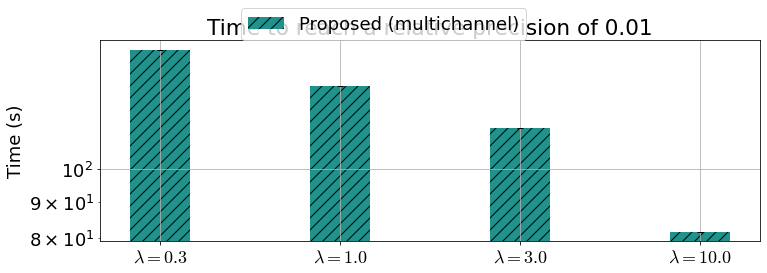

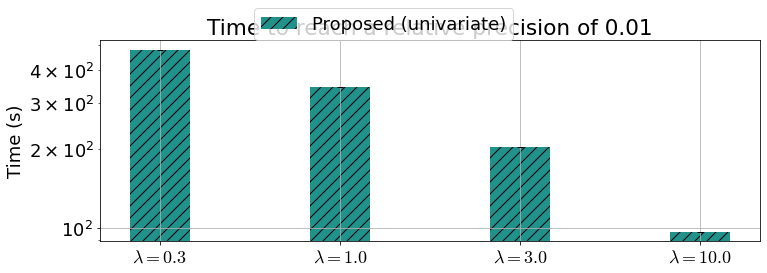

In [ ]:
all_results_df = None
for load_name in os.listdir('figures'):
    load_name = os.path.join('figures', load_name)
    if (load_name[-4:] == '.pkl' and
              ('run' in load_name or 'debug' in load_name)):
        print("load %s" % load_name)
        data_frame = pd.read_pickle(load_name)
    else:
          continue

    if all_results_df is not None:
          all_results_df = pd.concat([all_results_df, data_frame],
                                       ignore_index=True)
    else:
          all_results_df = data_frame

        # plot the results of each setting
    plot_convergence(data_frame, threshold=1e-2, normalize_method='last',
                         save_name=load_name[:-4])
    plt.close('all')

    # plot the aggregation of all results
plot_barplot(all_results_df, threshold=1e-2, normalize_method='last',
                 save_name=os.path.join('figures', 'all'))
#didn't add all the plots here but when you run the code, you can get a folder called figures that has all the plots
